# Message-passing neural network (MPNN) for molecular property prediction

In [ ]:
#!pip -q install rdkit-pypi
#!pip -q install pandas
#!pip -q install Pillow
#!pip -q install matplotlib
#!pip -q install pydot
#!sudo apt-get -qq install graphviz

### Import packages

In [59]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
from pathlib import Path
# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt

# Temporary suppress warnings
#warnings.filterwarnings("ignore")


np.random.seed(42)
tf.random.set_seed(42)

In [23]:
from constants import *

## Data

In [4]:
df = pd.read_csv("../data/0_raw/data.csv").reset_index(drop=True)
df.head(
)

,P1,mol_id,smiles
0,1,CID2999678,Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C
1,0,CID2999679,Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1
2,1,CID2999672,COc1cc2c(cc1NC(=O)CN1C(=O)NC3(CCc4ccccc43)C1=O...
3,0,CID5390002,O=C1/C(=C/NC2CCS(=O)(=O)C2)c2ccccc2C(=O)N1c1cc...
4,1,CID2999670,NC(=O)NC(Cc1ccccc1)C(=O)O


In [5]:
from data import validate_dataframe
df = validate_dataframe(df)

INFO:root: Data Validation | Dataset imbalance | Proportions: {1: 0.82, 0: 0.18}
INFO:root: Data Validation | Finished!


## Split to train/validation/test


Although scaffold splitting is recommended in our case (see
[here](https://www.blopig.com/blog/2021/06/out-of-distribution-generalisation-and-scaffold-splitting-in-molecular-property-prediction/)), for simplicity, random strattified splittings were
performed.

In [22]:
from data import split_data
split_data(data_path=INPUT_DATA_PATH,
           output_path=INTERMEDIATE_DATA_PATH,
           test_only=False,
          )

INFO:root: Data Validation | Dataset imbalance | Proportions: {1: 0.82, 0: 0.18}
INFO:root: Data Validation | Finished!
INFO:root: Data Splitting | Train: 0.7, Valid: 0.15, Test: 0.15
INFO:root: Data Splitting | Finished!


('../data/1_primary/data_train.csv',
 '../data/1_primary/data_valid.csv',
 '../data/1_primary/data_test.csv')

In [6]:
df_train = pd.read_csv(INTERMEDIATE_DATA_PATH/"data_train.csv")
df_valid = pd.read_csv(INTERMEDIATE_DATA_PATH/"data_valid.csv")
df_test = pd.read_csv(INTERMEDIATE_DATA_PATH/"data_test.csv")
len(df_train), len(df_valid), len(df_test)

(3499, 750, 750)

In [28]:
INTERMEDIATE_DATA_PATH

PosixPath('../data/1_primary')

In [33]:
from pathlib import Path
for path in INTERMEDIATE_DATA_PATH.glob("*.csv"):
  print(path)

../data/1_primary/data_train.csv
../data/1_primary/data_test.csv
../data/1_primary/data_valid.csv


In [48]:
import string    
import random # define the random module  
# call random.choices() string module to find the string in Uppercase + numeric data.  
ran = ''.join(random.choices(string.ascii_uppercase + string.digits, k = 7))    
print("The randomly generated string is : " + str(ran)) # print the random data  

The randomly generated string is : 9LCYWPE


In [35]:
list(INTERMEDIATE_DATA_PATH.glob("*.csv"))

[PosixPath('../data/1_primary/data_train.csv'),
 PosixPath('../data/1_primary/data_test.csv'),
 PosixPath('../data/1_primary/data_valid.csv')]

In [41]:
df = pd.concat(map(pd.read_csv, list(INTERMEDIATE_DATA_PATH.glob("*.csv")))).reset_index(drop=True)

In [42]:
df

,P1,mol_id,smiles
0,0,CID5309827,CC1=C(C(=O)Nc2cc(-c3cccc(F)c3)[nH]n2)C2(CCCCC2...
1,0,CID660162,CCOC(=O)CNC(=O)CSc1nc(C)cc(C)c1C#N
2,0,CID2565283,CC(C)(C)NC(=O)NC(=O)COc1ccccc1C#N
3,1,CID16190944,Cn1nccc1C(=O)N1CCCC(C(=O)c2cccc3ccccc23)C1
4,1,CID653298,O=C(Cn1c(C(=O)N2CCc3ccccc3C2)cc2sccc21)c1ccccc1
...,...,...,...
4994,0,CID892382,CCc1ccc(NC(=O)C2CCN(S(C)(=O)=O)CC2)cc1
4995,1,CID1441736,Fc1cccc(-c2cc3nc4c(c(NCc5ccco5)n3n2)CCCC4)c1
4996,1,CID5665590,N#C/C(C(=O)CN1CCOCC1)=C1\NC(c2ccccc2)=CS1
4997,1,CID3235902,O=C1NC(=O)C(CC(=O)N(Cc2ccco2)C2(C(=O)NC3CCCCC3...


In [ ]:
import os

all_files = os.listdir("/-to-dir")    
csv_files = list(filter(lambda f: f.endswith('.csv'), all_files))

In [27]:
df_train = pd.read_csv(INTERMEDIATE_DATA_PATH/"data_train.csv")

FileNotFoundError: [Errno 2] No such file or directory: '../data/1_primary/*.csv'

In [ ]:
df_train

## Featurization, Graph Generation & DataSet Creation


In [30]:
from data import get_mpnn_dataset
train_dataset, atom_dim, bond_dim = get_mpnn_dataset(df_train, return_dims=True)
valid_dataset = get_mpnn_dataset(df_valid,)
test_dataset = get_mpnn_dataset(df_test,)

In [32]:
FEATURE_DATA_PATH

PosixPath('../data/2_feature')

In [34]:
tf.data.experimental.save(train_dataset, "train_dataset")

In [37]:
train_dataset

<PrefetchDataset shapes: (((None, None), (None, None), (None, None), (None,)), (None,)), types: ((tf.float32, tf.float32, tf.int64, tf.int32), tf.int64)>

### Handle imbalance

In [35]:
tr_ds = tf.data.experimental.load("train_dataset")

In [9]:
from modeling import get_imbalance_params, MPNNModel
from data import get_mpnn_dataset

initial_bias, class_weight = get_imbalance_params(df_train)
initial_bias, class_weight

(array([1.52765758]), {0: 2.8036858974358974, 1: 0.6085217391304348})

In [22]:
def train(data_train_path, data_valid_path, save_model_path, reporting_path, handle_imbalance=False):
    df_train = pd.read_csv(data_train_path)
    df_train = validate_dataframe(df_train)
    
    train_dataset, atom_dim, bond_dim = get_mpnn_dataset(df_train, return_dims=True)
    
    if data_valid_path is not None:
        df_valid = pd.read_csv(data_valid_path)
        valid_dataset = get_mpnn_dataset(df_valid,)
    
    initial_bias=None
    class_weights=None
    if handle_imbalance==True:
        initial_bias, class_weight = get_imbalance_params(df_train)
    
    model = MPNNModel(
        atom_dim=atom_dim, bond_dim=bond_dim, output_bias=initial_bias,
    )
    
    model.compile(
        loss=tf.keras.losses.BinaryCrossentropy(),
        optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
        metrics=[tf.keras.metrics.AUC(name="AUC")],
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                  patience=5, min_lr=1e-7)
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,
    )
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        history = model.fit(
            train_dataset,
            validation_data=valid_dataset,
            epochs=MAX_EPOCHS,
            verbose=2,
            callbacks=[reduce_lr, early_stopping],
            class_weight=class_weight,
        )
    model.save(save_model_path)

    plt.figure(figsize=(10, 6))
    plt.plot(history.history["AUC"], label="train AUC")
    plt.plot(history.history["val_AUC"], label="valid AUC")
    plt.xlabel("Epochs", fontsize=16)
    plt.ylabel("AUC", fontsize=16)
    plt.legend(fontsize=16)
    plt.savefig(reporting_path/"training_history.png")

    return model, history

INFO:root: Data Validation | Dataset imbalance | Proportions: {1: 0.82, 0: 0.18}
INFO:root: Data Validation | Finished!


Epoch 1/2
110/110 - 120s - loss: 0.6846 - AUC: 0.5921 - val_loss: 0.5323 - val_AUC: 0.6705 - lr: 5.0000e-04 - 120s/epoch - 1s/step
Epoch 2/2
110/110 - 75s - loss: 0.6392 - AUC: 0.6913 - val_loss: 0.5674 - val_AUC: 0.6731 - lr: 5.0000e-04 - 75s/epoch - 681ms/step


INFO:tensorflow:Assets written to: ../data/3_model/mpnn_model/assets


INFO:tensorflow:Assets written to: ../data/3_model/mpnn_model/assets


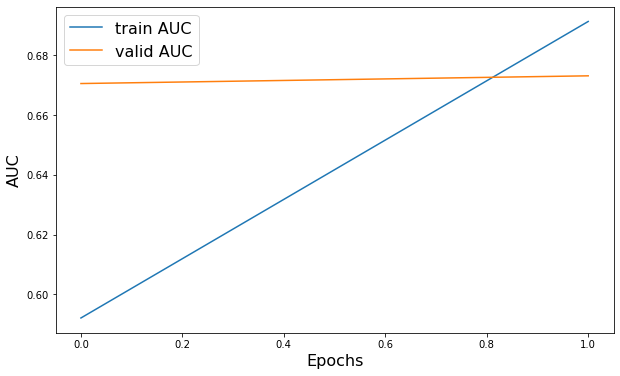

In [24]:
model, history = train(INTERMEDIATE_DATA_PATH/DATA_TRAIN_FILENAME, INTERMEDIATE_DATA_PATH/DATA_VALID_FILENAME, 
      save_model_path=MODEL_DATA_PATH/"mpnn_model",
      reporting_path=REPORTING_DATA_PATH,
      handle_imbalance=True,)

In [60]:
history.history

{'loss': [0.6846144199371338, 0.6392303705215454],
 'AUC': [0.5921438932418823, 0.6912787556648254],
 'val_loss': [0.5322723984718323, 0.5673941969871521],
 'val_AUC': [0.6705255508422852, 0.6731029152870178],
 'lr': [0.0005, 0.0005]}

In [62]:
import json
with open("history.json", 'w') as outfile:
        json.dump(str(history.history), outfile)

In [19]:
tf.keras.utils.plot_model(model, to_file='model.png', show_dtype=True, show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [26]:
fig = plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)
plt.close(fig)
plt.savefig("aa.png")

<Figure size 432x288 with 0 Axes>

In [ ]:
def evaluate(input_path, model_path, reporting_path):
    df_data = pd.read_pickle(data_path)
    dataset = get_mpnn_dataset(df_data)
    model = tf.keras.models.load_model(model_path)
    loss, auc = model.evaluate(dataset)
    results = {"loss": loss,
    "auc": auc,}
    return loss, auc

In [ ]:
loss, acc = evaluate(data_path=INTERMEDIATE_DATA_PATH/DATA_VALID_FILENAME,
        model_path="models/my_model",)

In [50]:
def predict(model_path, data_path=None, smiles=None):
    model = tf.keras.models.load_model(model_path)
    if (data_path is None) and (smiles is None):
        return "Error!"
    if data_path is not None:
        df_data = pd.read_pickle(data_path)
        dataset = get_mpnn_dataset(df_data)
        return  model.predict(dataset)
    if smiles is not None:
        dataset = get_mpnn_dataset(smiles)
        return model.predict(dataset)

In [ ]:
predictions = predict(model_path="models/my_model",
        data_path=INTERMEDIATE_DATA_PATH/DATA_TEST_FILENAME,
       )

In [52]:
preds = predict(model_path="../data/3_model/model",
        smiles=['CC1=C(C(=O)Nc2cc(-c3cccc(F)c3)[nH]n2)C2(CCCCC2)OC1=O',],
       )

In [53]:
preds

array([[0.88216656]], dtype=float32)

In [54]:
import tensorflow as tf

### Predicting

In [ ]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

In [ ]:
df.iloc[test_index].head(1).smiles.values

In [ ]:
sample = graphs_from_smiles(df.iloc[134:135].smiles.values)
len(sample)

In [ ]:
sample_dataset = MPNNDataset(sample, None)

In [ ]:
sample_preds = tf.squeeze(mpnn.predict(sample_dataset), axis=1)

In [ ]:
sample_preds

In [ ]:
len(sample)

In [ ]:
(1, 2, 3) + (4,)

In [ ]:
def evaluate(data_path, model_path):
    df_data = pd.read_csv(data_path)
    df_data = validate_dataframe(df_data)
    dataset = get_mpnn_dataset(df_data)
    model = tf.keras.models.load_model(model_path)
    return model.evaluate(dataset)

In [ ]:
loss, acc = evaluate(data_path=INTERMEDIATE_DATA_PATH/DATA_VALID_FILENAME,
        model_path="models/my_model",)

In [ ]:
def predict(model_path, data_path=None, smiles=None):
    model = tf.keras.models.load_model(model_path)
    if (data_path is None) and (smiles is None):
        raise Exception('No data input is given!')
    if data_path is not None:
        df_data = pd.read_csv(data_path)
        df_data = validate_dataframe(df_data, predict=True)
        if COL_TARGET not in df_data:
            df_data[COL_TARGET] = 0
        dataset = get_mpnn_dataset(df_data)
        return  model.predict(dataset)
    if smiles is not None:
        dataset = get_mpnn_dataset(smiles)
        return model.predict(dataset)

In [ ]:
predictions = predict(model_path="models/my_model",
        data_path=INTERMEDIATE_DATA_PATH/DATA_TEST_FILENAME,
       )

In [ ]:
df["smiles"]

In [ ]:
predictions

In [ ]:
predict(model_path="models/my_model", smiles=["Cc1cccc(N2CCN(C(=O)C34CC5CC(CC(C5)C3)C4)CC2)c1C",
                                             "Cn1ccnc1SCC(=O)Nc1ccc(Oc2ccccc2)cc1"])